In [1]:
from sklearn.svm import LinearSVC
from art.utils import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from art.estimators.classification import KerasClassifier
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

/home/cmeyers/anaconda3/envs/art/lib/python3.8/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")
2023-05-12 00:29:39.453692: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-12 00:29:39.516006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 00:29:40.651248: W tensorflow/compiler/tf2tensorrt/utils/py

In [2]:
# X, y = load_digits(return_X_y=True)
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)
(X_train, y_train), (X_test, y_test), min_, max_ = load_dataset("mnist")
# model = LinearSVC(max_iter=10)
# model.fit(X_train.reshape(len(np.argmax(y_train, axis=1)), 784), np.argmax(y_train, axis=1))
# clf = ScikitlearnSVC(model=model, clip_values=(min_, max_))

from keras.models import load_model
path = "./mnist/model.h5"
model = load_model(path)
clf = KerasClassifier(model=model, use_logits=False, clip_values=(min_, max_))
attack_size = 1
attack = ProjectedGradientDescent(clf, eps=0.3, batch_size = attack_size)
X_test_adv = attack.generate(X_test[:attack_size])


Instructions for updating:
Colocations handled automatically by placer.


2023-05-12 00:29:45.272259: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-12 00:29:47.088728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-12 00:29:47.309732: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_6_2_1/bias/Assign' id:1431 op device:{requested: '', assigned: ''} def:{{{node conv2d_6_2_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_6_2_1/bias, conv2d_6_2_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in th

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

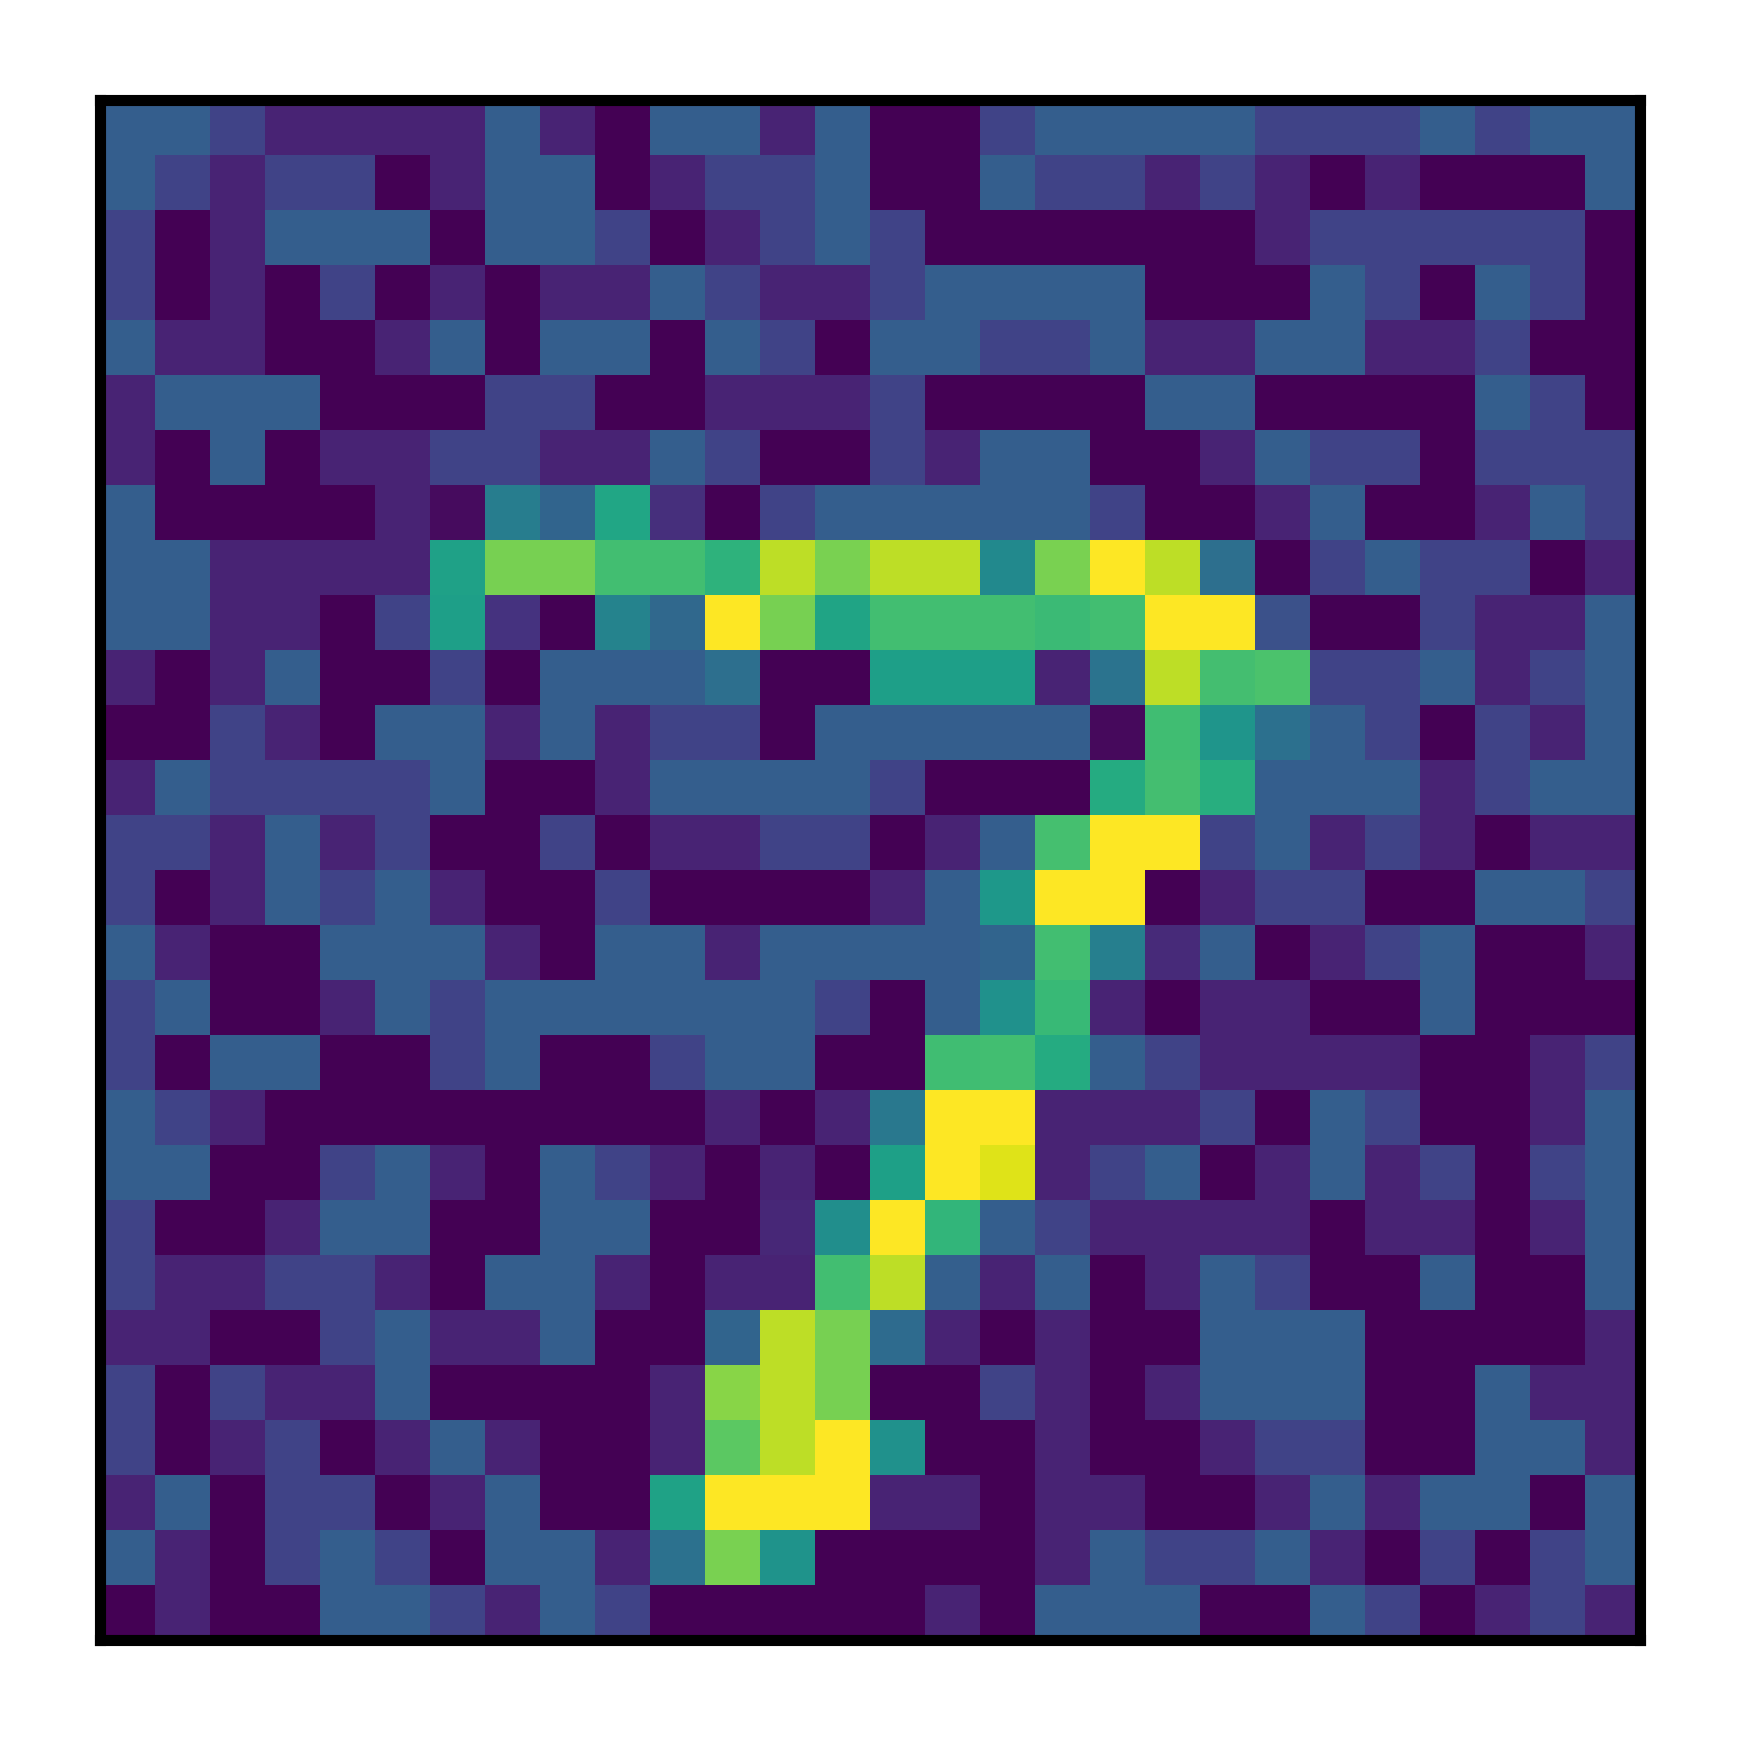

In [3]:
X_test_adv = X_test_adv[0].reshape(1, 28, 28)
fig, ax = plt.subplots(1, 1)
plot = ax.imshow(X_test_adv[0])
plot.axes.set_xticks([])
plot.axes.set_yticks([])
fig.set_size_inches(2, 2)
fig.set_dpi(1000)
# fig.tight_layout()
fig.savefig(f"noisy_number.eps", format="eps", dpi=1000)

In [4]:
# !python generate.py
# !python plot.py

In [15]:


from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import CarliniL2Method
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Times New Roman'

# Adapted from : https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/classifier_scikitlearn_SVC_LinearSVC.ipynb

def get_adversarial_examples(x_train, y_train, kernel, model_type=None, attack='PGD'):
    
    # Create and fit LinearSVC or SVC
    if model_type == 'LinearSVC':
        model = LinearSVC()
    else:
        model = SVC(C=1.0, kernel=kernel, degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, 
                    tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
                    decision_function_shape='ovr', random_state=None)
    model.fit(X=x_train, y=y_train)

    #  Create ART classifier for scikit-learn SVC
    art_classifier = SklearnClassifier(model=model, clip_values=(0, 10))

    # Create ART attack
    if attack == 'PGD':
        attacker = ProjectedGradientDescent(estimator=art_classifier, norm=1, eps=1.0, eps_step=0.1,
                                            max_iter=10, targeted=False, num_random_init=0, batch_size=1,
                                            verbose=False)
    elif attack == 'CW':
        attacker = CarliniL2Method(classifier=art_classifier, max_iter=20, verbose=False)
            
    # Generate adversarial samples 
    x_train_adv = attacker.generate(x_train)

    return x_train_adv, model
    return 0, 0

def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] -= 2
    x_train[:, 1][y_train == 2] += 2
    return x_train, y_train

def plot_results(model, x_train, y_train, x_train_adv, num_classes, model_type=None):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1],
                                 s=20, zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 1.5, 8.5
        y_min, y_max = 0, 7

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        if model_type is None and model.probability:
            Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
            Z_proba = Z_proba[:, i_class].reshape(xx.shape)
            im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                       vmin=0, vmax=1)
            if i_class == num_classes - 1:
                cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
                plt.colorbar(im, ax=axs[i_class], cax=cax)
        else:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i_class].contour(xx, yy, Z, cmap=plt.cm.Paired)

        # Plot adversarial samples
        axs[i_class].scatter(x_train_adv[y_train == i_class][:, 0], x_train_adv[y_train == i_class][:, 1],
                             zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('Class ' + str(i_class))
        axs[i_class].set_xlabel('Feature 1')
        axs[i_class].set_ylabel('Feature 2')
    return fig, axs

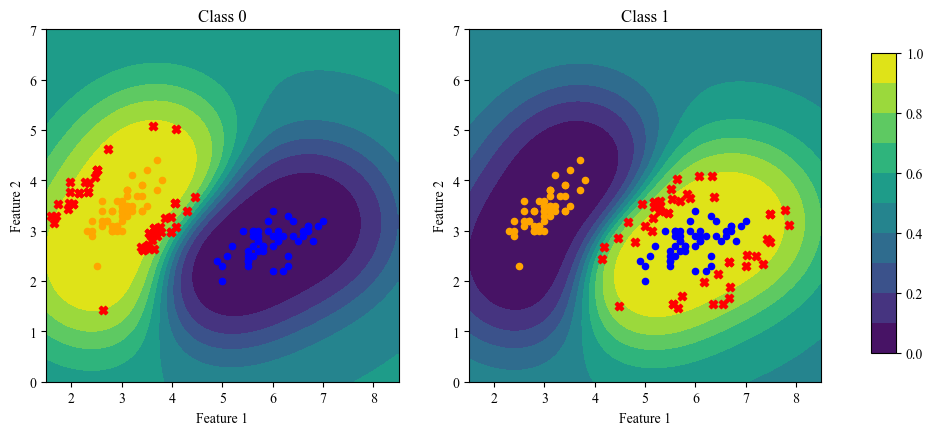

In [17]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', attack='PGD')
fig, axs = plot_results(model, x_train, y_train, x_train_adv, num_classes)
fig.savefig(f"contour.eps", format="eps", dpi=1000)